In [1]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import random

In [2]:
# Import only the classes used by encoder and decoder as we need 2 channel input to encoder and is defined below
from pl_bolts.models.autoencoders.components import (
    # resnet18_decoder,
    # resnet18_encoder,
    ResNetEncoder,
    ResNetEncoder,
    EncoderBlock,
    DecoderBlock,
    conv1x1,
    resize_conv1x1,
    Interpolate,
)

/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Un

In [3]:
## Copied from the lightning bolt repo to modify the self.conv1 input to 2 channel instead of 3 (encoder will have labels as channel-2 input)
class ResNetEncoder(nn.Module):
    def __init__(self, block, layers, first_conv=False, maxpool1=False) -> None:
        super().__init__()

        self.inplanes = 64
        self.first_conv = first_conv
        self.maxpool1 = maxpool1

        if self.first_conv:
            self.conv1 = nn.Conv2d(2, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.conv1 = nn.Conv2d(2, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        if self.maxpool1:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return torch.flatten(x, 1)

In [4]:
# Copied from the lightning bolt repo to change the upscale_factor to 4 and decrease the scale to 1 in self.layer1 definition. 
# This will help to process mnist images with their size 0f 28x28 (encoder will have labels as channel-2 input)
class ResNetDecoder(nn.Module):
    """Resnet in reverse order."""

    def __init__(self, block, layers, latent_dim, input_height, first_conv=False, maxpool1=False) -> None:
        super().__init__()

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.upscale_factor = 4

        self.linear = nn.Linear(latent_dim, self.inplanes * 4 * 4)

        self.layer1 = self._make_layer(block, 256, layers[0], scale=1)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2)

        if self.maxpool1:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2)
            self.upscale_factor *= 2
        else:
            self.layer4 = self._make_layer(block, 64, layers[3])

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2
        else:
            self.upscale = Interpolate(scale_factor=1)

        # interpolate after linear layer using scale factor
        self.upscale1 = Interpolate(size=input_height // self.upscale_factor)

        self.conv1 = nn.Conv2d(64 * block.expansion, 1, kernel_size=3, stride=1, padding=1, bias=False)

    def _make_layer(self, block, planes, blocks, scale=1):
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.linear(x)

        # NOTE: replaced this by Linear(in_channels, 514 * 4 * 4)
        # x = F.interpolate(x, scale_factor=4)

        x = x.view(x.size(0), 512 * self.expansion, 4, 4)
        # print(x.shape)
        x = self.upscale1(x)
        # print('upscale 1 ', x.shape)
        x = self.layer1(x)
        # print('layer 1 ', x.shape)
        x = self.layer2(x)
        # print('layer 2 ', x.shape)
        x = self.layer3(x)
        # print('layer 3 ', x.shape)
        x = self.layer4(x)
        # print('before upscale ', x.shape)
        x = self.upscale(x)
        # print('after upscale ', x.shape)
        return self.conv1(x)


In [5]:
def resnet18_encoder(first_conv, maxpool1):
    return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)


def resnet18_decoder(latent_dim, input_height, first_conv, maxpool1):
    return ResNetDecoder(DecoderBlock, [2, 2, 2, 2], latent_dim, input_height, first_conv, maxpool1)


In [ ]:
# resnet18_encoder(False, False)

In [ ]:
# resnet18_decoder(
#     latent_dim=256,
#     input_height=28, 
#     first_conv=False, 
#     maxpool1=False
# )

In [6]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=28):   # 512, 256
        super().__init__()

        self.save_hyperparameters()
        self.input_height = input_height

        self.label_embed = nn.Embedding(10, embedding_dim=input_height)
        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, label = batch
        # print(x.shape)

        # convert label to on_hot encoding and pass it thru an embedding layer to include it as input
        label_onehot = nn.functional.one_hot(label, num_classes=10)
        label_embed = self.label_embed(label_onehot).to(self.device).unsqueeze(dim=1)

        # Pad the embedded label to the same size as input imag with zeros as padding
        self.padder = torch.zeros(x.shape[0], 1, self.input_height-10, self.input_height).to(self.device)
        padded_label_embed = torch.cat([label_embed,self.padder], dim = 2).to(self.device)

        # add padded embedded label as second channel to the input image
        x_with_label = torch.cat([x, padded_label_embed], dim=1)
        
        # encode x_with_label to get the mu and variance parameters
        x_encoded = self.encoder(x_with_label)

        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

In [7]:
from pl_bolts.datamodules import CIFAR10DataModule, MNISTDataModule

# datamodule = CIFAR10DataModule('.')
datamodule = MNISTDataModule('.')

In [8]:
# DATA
# we're pretending to have an image from cifar-10 + Label (4 channels, 32x32 pixels)
vae_tmp = VAE(input_height=28)
x = torch.rand(1,2, 28, 28)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae_tmp.encoder(x)
mu, log_var = vae_tmp.fc_mu(x_encoded), vae_tmp.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

/tmp/ipykernel_19071/62022266.py:37: UnderReviewWarning: The feature EncoderBlock is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  layers.append(block(self.inplanes, planes, stride, downsample))
/home/sn/anaconda3/envs/fastai2022/lib/python3.9/site-packages/pl_bolts/models/autoencoders/components.py:56: UnderReviewWarning: The feature conv3x3 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.conv1 = conv3x3(inplanes, planes, stride)
/tmp/ipykernel_19071/62022266.py:32: UnderReviewWarning: The feature conv1x1 is current

image shape: torch.Size([1, 2, 28, 28])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


In [9]:
pl.seed_everything(1234)

vae = VAE(input_height=28)
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=30) # progress_bar_refresh_rate=10)
trainer.fit(vae, datamodule=datamodule)

Global seed set to 1234
/tmp/ipykernel_19071/62022266.py:37: UnderReviewWarning: The feature EncoderBlock is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  layers.append(block(self.inplanes, planes, stride, downsample))
/tmp/ipykernel_19071/62022266.py:32: UnderReviewWarning: The feature conv1x1 is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  conv1x1(self.inplanes, planes * block.expansion, stride),
/tmp/ipykernel_19071/3070788848.py:42: UnderReviewWarning: The feature resize_conv1x1 is currently marked under review. The c

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 1, 28, 28])


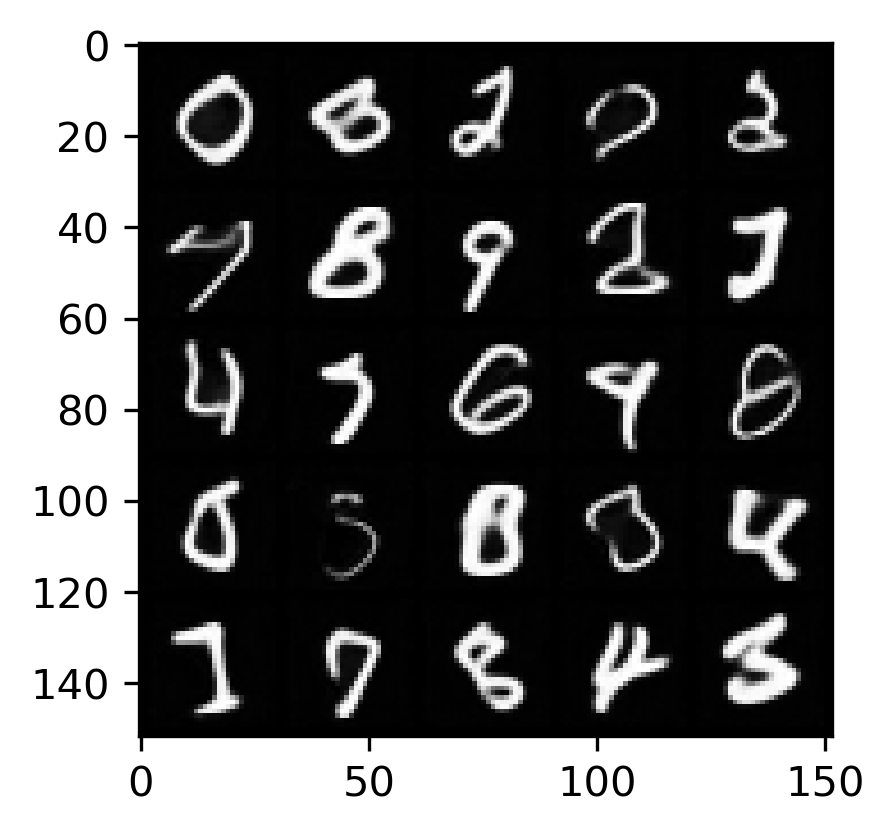

In [13]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 25
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

print(pred.shape)
img = make_grid(pred, 5).permute(1, 2, 0).numpy() # * std + mean

# PLOT IMAGES
imshow(img);

In [14]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Plot result of image with wrong label as input

In [23]:
def get_wrong_label(label_list):
    new_list = []
    for n in label_list:
        list_10 = list(range(10))
        list_10.pop(n)
        new_list.append(random.choice(list_10))
    return new_list

In [24]:
# get  a random batch of 512 images
new_batch = next(iter(datamodule.train_dataloader()))

In [25]:
# pick the first 25 images and their label for input
val_batch = [new_batch[0][:25], new_batch[1][:25]]

In [26]:
val_batch

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [28]:
import random

In [29]:
x_val, label_true = val_batch

label_val =  torch.tensor(get_wrong_label(label_true.tolist()))
label_val, label_true

(tensor([8, 1, 0, 1, 1, 1, 1, 6, 3, 0, 0, 0, 5, 8, 8, 2, 2, 3, 2, 1, 9, 7, 4, 1,
         9]),
 tensor([4, 9, 1, 2, 0, 9, 4, 3, 9, 6, 4, 2, 6, 4, 7, 5, 1, 1, 0, 0, 3, 9, 2, 3,
         4]))

In [30]:
x_val.shape

torch.Size([25, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label  [4, 9, 1, 2, 0, 9, 4, 3, 9, 6, 4, 2, 6, 4, 7, 5, 1, 1, 0, 0, 3, 9, 2, 3, 4]
wrong Label  [8, 1, 0, 1, 1, 1, 1, 6, 3, 0, 0, 0, 5, 8, 8, 2, 2, 3, 2, 1, 9, 7, 4, 1, 9]


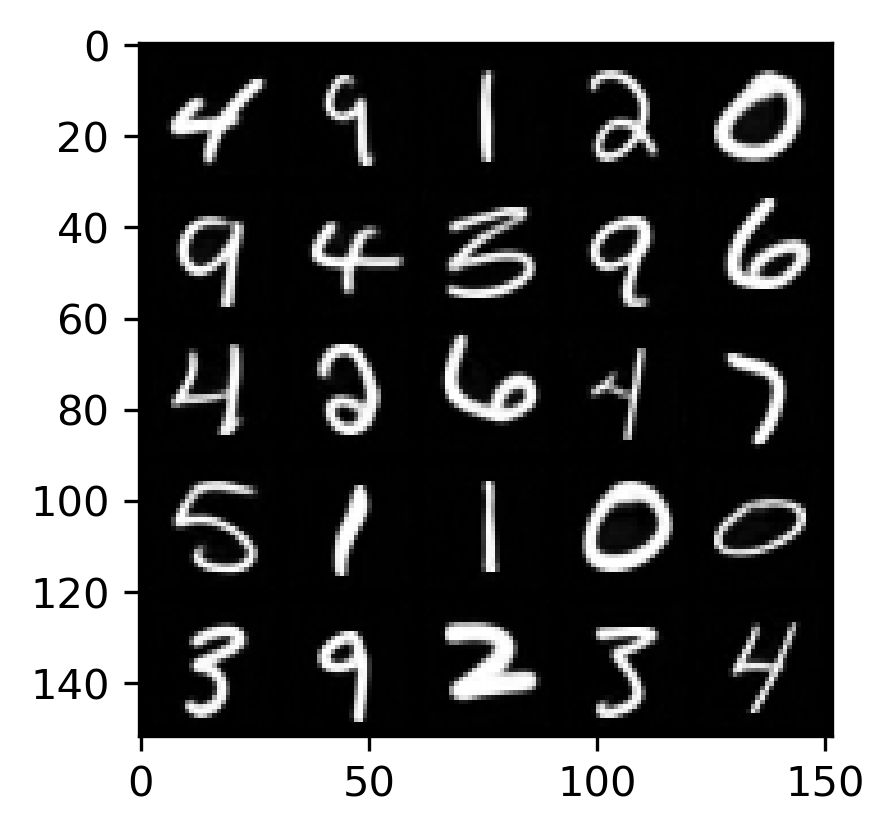

In [34]:
figure(figsize=(8, 3), dpi=300)
label_onehot = nn.functional.one_hot(label_val, num_classes=10)
label_embed = vae.label_embed(label_onehot).to(vae.device).unsqueeze(dim=1)
val_padder = torch.zeros(x_val.shape[0], 1, vae.input_height-10, vae.input_height).to(vae.device)
padded_label_embed = torch.cat([label_embed,val_padder], dim = 2).to(vae.device)
x_val_with_label = torch.cat([x_val, padded_label_embed], dim=1)
# print('final x shape ', x.shape)

# encode x to get the mu and variance parameters
with torch.no_grad():
    x_val_encoded = vae.encoder(x_val_with_label)
mu, log_var = vae.fc_mu(x_val_encoded), vae.fc_var(x_val_encoded)

# sample z from q
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()
# z = torch.cat([q.rsample(), label_onehot], dim=1)

# decoded 
with torch.no_grad():
    pred_val = vae.decoder(z.to(vae.device)).cpu()

# print(pred_val.shape)
# UNDO DATA NORMALIZATION
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred_val, 5).permute(1, 2, 0).numpy()  #* std + mean

print("True Label ", label_true.tolist())
print("wrong Label ", label_val.tolist())
# PLOT IMAGES
imshow(img);

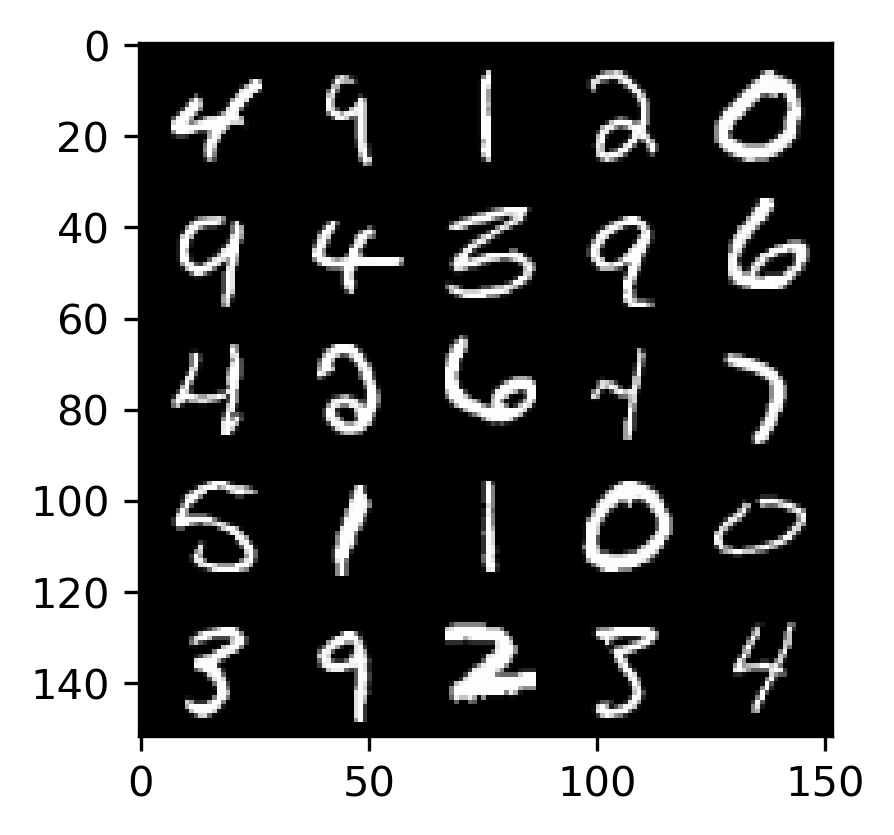

In [38]:
# Actual Images without passing thru VAE
figure(figsize=(8, 3), dpi=300)
img = make_grid(val_batch[0], 5).permute(1, 2, 0).numpy()
imshow(img)